## Importing the modules

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torchvision.transforms as T
import torchvision.models as models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from torch.utils.data import random_split

import cv2
import PIL
from PIL import Image


import functools

## Preparing the data

In [2]:
## initialization
IMG_SHAPE = (256,256)
VAL_DATASET_SIZE = 0.1 
BATCH_SIZE = 128
DATASET_SIZE = 0.1

In [3]:
DATA_DIR = "../input/food41/images"

transform_ds = T.Compose([
    T.Resize(IMG_SHAPE),
    T.RandomHorizontalFlip(),
    T.ColorJitter(hue=.05, saturation=.05),
    T.RandomRotation(20, resample=PIL.Image.BILINEAR),
    T.ToTensor()
])

ds = torchvision.datasets.ImageFolder(
    root=DATA_DIR,
    transform=transform_ds

)

print("total images = ", len(ds))

total images =  101000


In [4]:
ds.classes

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [5]:
val_ds_size = int(len(ds) * VAL_DATASET_SIZE)
train_ds_size = len(ds) - val_ds_size

train_ds, val_ds = random_split(ds, [train_ds_size, val_ds_size])

In [6]:
train_dl = DataLoader(train_ds, BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, BATCH_SIZE, num_workers=4, pin_memory=True)

In [7]:
def show_images(train_dl):
    for images, labels in train_dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:32], nrow=8).permute(1,2,0))
        break

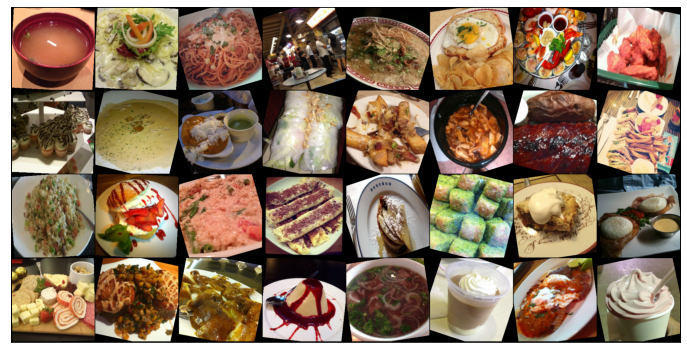

In [8]:
show_images(train_dl)

## Moving the data to the GPU

In [9]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

@functools.lru_cache(maxsize=128)
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for x in self.dl:
            yield to_device(x, self.device)
            
    def __len__(self):
        return len(self.dl)

In [10]:
device = get_device()
device

device(type='cuda')

In [11]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

## Defining the Model

In [12]:
def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [13]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {"val_loss": loss.detach(), "val_acc": acc}
    
    def validation_epoch_end(self, outputs):
        batch_loss = [x["val_loss"] for x in outputs]
        epoch_loss = torch.stack(batch_loss).mean()
        batch_acc = [x["val_acc"] for x in outputs]
        epoch_acc = torch.stack(batch_acc).mean()
        return {"val_loss": epoch_loss.item(), "val_acc": epoch_acc.item()}
    
    def epoch_end(self, epoch, epochs, result):
        print("Epoch: [{}/{}], last_lr: {:.6f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, epochs, result["lrs"][-1], result["train_loss"], result["val_loss"], result["val_acc"]))

In [14]:
network = models.resnet50(pretrained=True)
network.fc

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Linear(in_features=2048, out_features=1000, bias=True)

In [15]:
network

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
class Classifier(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = models.resnet50(pretrained=True)
        number_of_features =  self.network.fc.in_features
        self.network.fc = nn.Linear(number_of_features, 101)
        
    def forward(self, xb):
        return self.network(xb)
        
    def freeze(self):
        for param in self.network.parameters():
            param.requires_grad=False
        for param in self.network.fc.parameters():
            param.requires_grad=True
        
    def unfreeze(self):
        for param in self.network.parameters():
            param.requires_grad=True

In [17]:
model = to_device(Classifier(), device)

## Training

In [18]:
@torch.no_grad()
def evaluate(model, val_dl):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_dl]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]
    
def fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=0, grad_clip=None,
                 opt_func=torch.optim.Adam):
    
    torch.cuda.empty_cache()
    
    history = []
    opt = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    sched = torch.optim.lr_scheduler.OneCycleLR(opt, max_lr, epochs=epochs,
                                                   steps_per_epoch=len(train_dl))
    
    for epoch in range(epochs):
        model.train()
        train_loss = []
        lrs = []
        for batch in tqdm(train_dl):
            loss = model.training_step(batch)
            train_loss.append(loss)
            loss.backward()
            
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
                
            opt.step()
            opt.zero_grad()
            
            lrs.append(get_lr(opt))
            sched.step()
            
        result = evaluate(model, val_dl)
        result["train_loss"] = torch.stack(train_loss).mean().item()
        result["lrs"] = lrs
        model.epoch_end(epoch, epochs, result)
        history.append(result)
    return history
    

In [19]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 4.672759532928467, 'val_acc': 0.015130537562072277}]

In [20]:
model.freeze()

In [21]:
epochs = 7
max_lr = 10e-5
grad_clip = 0.1
weight_decay = 10e-4
opt_func=torch.optim.Adam

In [22]:
%%time

history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=weight_decay,
                        grad_clip=grad_clip, opt_func=opt_func)


Epoch: [0/7], last_lr: 0.000048, train_loss: 4.5093, val_loss: 4.1937, val_acc: 0.2091



Epoch: [1/7], last_lr: 0.000099, train_loss: 3.6398, val_loss: 3.1033, val_acc: 0.4075



Epoch: [2/7], last_lr: 0.000092, train_loss: 2.7954, val_loss: 2.5671, val_acc: 0.4554



Epoch: [3/7], last_lr: 0.000067, train_loss: 2.4344, val_loss: 2.3467, val_acc: 0.4745



Epoch: [4/7], last_lr: 0.000036, train_loss: 2.2815, val_loss: 2.2639, val_acc: 0.4891



Epoch: [5/7], last_lr: 0.000010, train_loss: 2.2112, val_loss: 2.2228, val_acc: 0.4898



Epoch: [6/7], last_lr: 0.000000, train_loss: 2.1925, val_loss: 2.2102, val_acc: 0.4984
CPU times: user 4min 28s, sys: 2min 23s, total: 6min 52s
Wall time: 2h 18min


In [23]:
model.unfreeze()

In [24]:
%%time

history += fit_one_cycle(epochs, max_lr, model, train_dl, val_dl, weight_decay=weight_decay,
                        grad_clip=grad_clip, opt_func=opt_func)


Epoch: [0/7], last_lr: 0.000048, train_loss: 1.5848, val_loss: 1.2046, val_acc: 0.6837



Epoch: [1/7], last_lr: 0.000099, train_loss: 1.0191, val_loss: 1.0046, val_acc: 0.7329



Epoch: [2/7], last_lr: 0.000092, train_loss: 0.7876, val_loss: 0.9526, val_acc: 0.7463



Epoch: [3/7], last_lr: 0.000067, train_loss: 0.6071, val_loss: 0.7961, val_acc: 0.7849



Epoch: [4/7], last_lr: 0.000036, train_loss: 0.4377, val_loss: 0.7054, val_acc: 0.8140



Epoch: [5/7], last_lr: 0.000010, train_loss: 0.2942, val_loss: 0.6636, val_acc: 0.8217



Epoch: [6/7], last_lr: 0.000000, train_loss: 0.2190, val_loss: 0.6507, val_acc: 0.8282
CPU times: user 20min, sys: 11min 48s, total: 31min 48s
Wall time: 2h 32min 33s


## Performance

Text(0, 0.5, 'Accuracy')

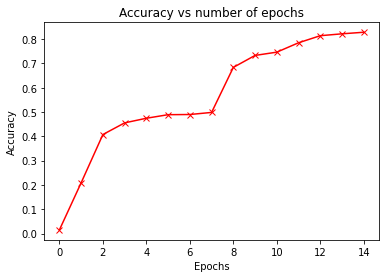

In [25]:
accuracy = [x["val_acc"] for x in history]
plt.plot(accuracy, "-rx")
plt.title("Accuracy vs number of epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")

Text(0.5, 0, 'Epochs')

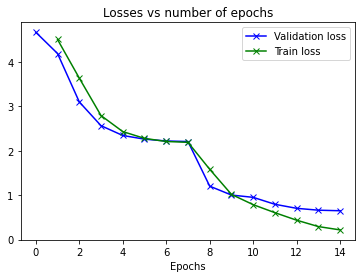

In [26]:
val_loss = [x["val_loss"] for x in history]
train_loss = [x.get("train_loss") for x in history]
plt.plot(val_loss, "-bx")
plt.plot(train_loss, "-gx")
plt.title("Losses vs number of epochs")
plt.legend(["Validation loss", "Train loss"])
plt.xlabel("Epochs")

## Save & Load 

In [27]:
torch.save(model, "/kaggle/working/mod.pth")
model = torch.load('mod.pth', map_location=torch.device('cuda') )

for parameter in model.parameters():
    parameter.requires_grad = False

model.eval()

/opt/conda/lib/python3.7/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Classifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Classifier(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
       

## Evaluation

In [28]:
test_transforms = T.Compose([T.Resize(256),
                                      T.ToTensor(),
                                      ])

def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
#     input = Variable(image_tensor)
    input = image_tensor.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

img = Image.open('../input/food41/images/club_sandwich/1017761.jpg')
# to_pil = transforms.ToPILImage()

# image = to_pil(img)
index = predict_image(img)
print(index)
print(ds.classes[index])

25
club_sandwich


In [29]:
# checkpoint = {
#               'model': Classifier(),
#               'state_dict': model.state_dict(),
#               'optimizer':opt_func.state_dict(),
#              }
# torch.save(checkpoint, "/kaggle/working/model_state_dict.pth")
